In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, Bidirectional, LSTM, Dropout, TimeDistributed, Flatten, Dense
from keras.callbacks import EarlyStopping

# Thiết lập thiết bị
import tensorflow as tf
print("Số lượng GPU khả dụng: ", len(tf.config.list_physical_devices('GPU')))

Số lượng GPU khả dụng:  0


c:\PythonEnvs\global-env\Lib\site-packages\keras\src\export\tf2onnx_lib.py:8: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, "object"):


In [4]:
# 1. Tải dữ liệu
df = pd.read_csv("../data/yfinance_data2.csv")
df['date'] = pd.to_datetime(df['date'])
ticker = 'NVDA' 
data = df[df['symbol'] == ticker].sort_values('date')
data["band_width"] = data["upper_band"] - data["lower_band"]

features_cols = ['close_price','volume', 
                  'MACD', 'RSI', 'ATR', 'return_pct', 'volatility_14', 'band_width']
dataset = data[features_cols].values

# 3. Chuẩn hóa Min-Max (Giúp LSTM hội tụ tốt hơn Standard)
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)

# 4. Tạo cấu trúc dữ liệu cho TimeDistributed CNN-LSTM
def create_complex_sequences(data, n_steps, n_seq, n_features):
    X, y = [], []
    window_size = n_steps * n_seq
    for i in range(window_size, len(data)):
        seq_x = data[i-window_size:i, :]
        X.append(seq_x.reshape((n_seq, n_steps, n_features)))
        y.append(data[i, 0]) # Dự báo giá Close
    return np.array(X), np.array(y)

N_STEPS = 10
N_SEQ = 5
N_FEATURES = len(features_cols)

X, y = create_complex_sequences(scaled_data, N_STEPS, N_SEQ, N_FEATURES)

# Chia Train/Test (80/20)
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

print(f"Shape đầu vào (X_train): {X_train.shape}") # (samples, 5, 10, 12)

Shape đầu vào (X_train): (2148, 5, 10, 8)


In [5]:
# Sửa lại hàm tạo chuỗi: Không chia sub-sequences, giữ nguyên window 50 ngày
def create_sequences_paper(data, window_size=50):
    X, y = [], []
    for i in range(window_size, len(data)):
        # Lấy window_size dòng (50 ngày) làm đầu vào
        X.append(data[i-window_size:i, :])
        # Dự báo giá Close (cột 0) của ngày tiếp theo
        y.append(data[i, 0])
    return np.array(X), np.array(y)

WINDOW_SIZE = 50 # Theo bài báo
X, y = create_sequences_paper(scaled_data, WINDOW_SIZE)

# Chia Train/Test (80/20)
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

print(f"Shape đầu vào mới (X_train): {X_train.shape}") 
# Kỳ vọng: (Số mẫu, 50, 8) - Tương ứng (Samples, Time Steps, Features)

Shape đầu vào mới (X_train): (2148, 50, 8)


In [6]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, Bidirectional, LSTM, Dense, Dropout, concatenate

def create_pipeline(inputs, kernel_size):
    # Mỗi luồng gồm 3 lớp CNN (theo bài báo)
    x = Conv1D(filters=64, kernel_size=kernel_size, activation='relu', padding='same')(inputs)
    x = Conv1D(filters=64, kernel_size=kernel_size, activation='relu', padding='same')(x)
    x = Conv1D(filters=64, kernel_size=kernel_size, activation='relu', padding='same')(x)
    
    # 2 lớp Bi-directional LSTM
    x = Bidirectional(LSTM(64, return_sequences=True))(x)
    x = Bidirectional(LSTM(64))(x)
    x = Dropout(0.2)(x)
    return x

# Định nghĩa Input
input_layer = Input(shape=(X_train.shape[1], X_train.shape[2]))

# Tạo 3 luồng với kernel_size khác nhau (3, 5, 7) để bắt các nhịp thị trường khác nhau
branch1 = create_pipeline(input_layer, 3)
branch2 = create_pipeline(input_layer, 5)
branch3 = create_pipeline(input_layer, 7)

# Gộp kết quả từ 3 luồng
merged = concatenate([branch1, branch2, branch3])

# Tầng đầu ra
output = Dense(1)(merged)

model = Model(inputs=input_layer, outputs=output)
model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 50, 8)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 50, 64)    │      1,600 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_3 (Conv1D)   │ (None, 50, 64)    │      2,624 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_6 (Conv1D)   │ (None, 50, 64)    │      3,648 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 50, 64)    │     12,352 │ conv1d[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_4 (Conv1D)   │ (None, 50, 64)    │     20,544 │ conv1d_3[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_7 (Conv1D)   │ (None, 50, 64)    │     28,736 │ conv1d_6[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2 (Conv1D)   │ (None, 50, 64)    │     12,352 │ conv1d_1[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_5 (Conv1D)   │ (None, 50, 64)    │     20,544 │ conv1d_4[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_8 (Conv1D)   │ (None, 50, 64)    │     28,736 │ conv1d_7[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional       │ (None, 50, 128)   │     66,048 │ conv1d_2[0][0]    │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_2     │ (None, 50, 128)   │     66,048 │ conv1d_5[0][0]    │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_4     │ (None, 50, 128)   │     66,048 │ conv1d_8[0][0]    │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_1     │ (None, 128)       │     98,816 │ bidirectional[0]… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_3     │ (None, 128)       │     98,816 │ bidirectional_2[… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_5     │ (None, 128)       │     98,816 │ bidirectional_4[… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 128)       │          0 │ bidirectional_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 128)       │          0 │ bidirectional_3[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 128)       │          0 │ bidirectional_5[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 384)       │          0 │ dropout[0][0],    │
│ (Concatenate)       │                   │            │ dropout_1[0][0],  │
│                     │                   │            │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 626,113 (2.39 MB)

 Trainable params: 626,113 (2.39 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
68/68 ━━━━━━━━━━━━━━━━━━━━ 26s 138ms/step - loss: 0.0028 - val_loss: 0.0315
Epoch 2/100
68/68 ━━━━━━━━━━━━━━━━━━━━ 22s 319ms/step - loss: 1.1671e-04 - val_loss: 0.0213
Epoch 3/100
68/68 ━━━━━━━━━━━━━━━━━━━━ 22s 324ms/step - loss: 6.8023e-05 - val_loss: 0.0112
Epoch 4/100
68/68 ━━━━━━━━━━━━━━━━━━━━ 18s 265ms/step - loss: 6.1800e-05 - val_loss: 0.0223
Epoch 5/100
68/68 ━━━━━━━━━━━━━━━━━━━━ 32s 439ms/step - loss: 6.3982e-05 - val_loss: 0.0103
Epoch 6/100
68/68 ━━━━━━━━━━━━━━━━━━━━ 16s 233ms/step - loss: 5.1930e-05 - val_loss: 0.0135
Epoch 7/100
68/68 ━━━━━━━━━━━━━━━━━━━━ 12s 114ms/step - loss: 6.1049e-05 - val_loss: 0.0160
Epoch 8/100
68/68 ━━━━━━━━━━━━━━━━━━━━ 18s 273ms/step - loss: 3.0459e-05 - val_loss: 0.0106
Epoch 9/100
68/68 ━━━━━━━━━━━━━━━━━━━━ 26s 360ms/step - loss: 3.2747e-05 - val_loss: 0.0076
Epoch 10/100
68/68 ━━━━━━━━━━━━━━━━━━━━ 48s 470ms/step - loss: 2.8734e-05 - val_loss: 0.0064
Epoch 11/100
68/68 ━━━━━━━━━━━━━━━━━━━━ 37s 407ms/step - loss: 4.2389e-05 - val_los

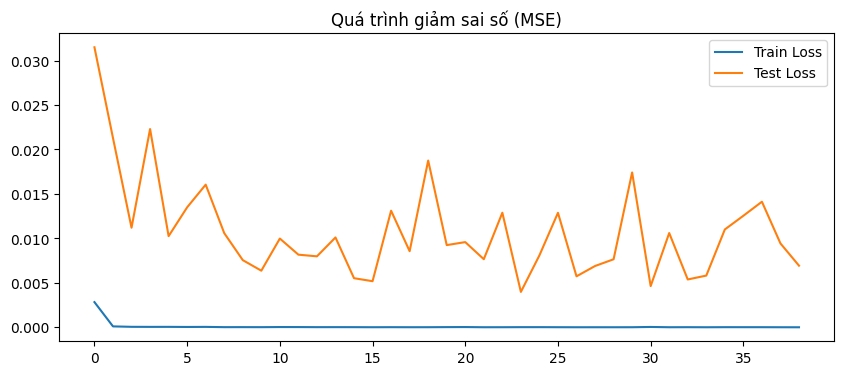

In [7]:
from tensorflow.keras.callbacks import EarlyStopping

# Tự động dừng và giữ lại trọng số tốt nhất
early_stop = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=100,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)

# Vẽ đồ thị Loss
plt.figure(figsize=(10, 4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.title("Quá trình giảm sai số (MSE)")
plt.legend()
plt.show()

17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 120ms/step


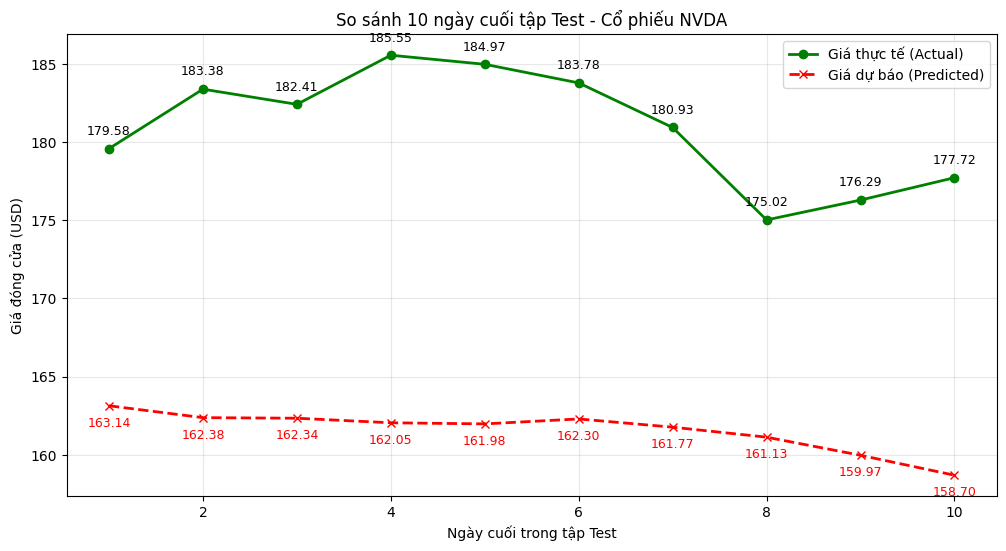

Sai số trung bình (MAE) trong 10 ngày cuối: 19.39 USD


In [9]:
# 1. Dự báo trên tập Test
y_pred_scaled = model.predict(X_test)

# 2. Nghịch đảo chuẩn hóa (Inverse Transform) để về giá USD
def inverse_y(y_val, scaler, n_feat):
    dummy = np.zeros((len(y_val), n_feat))
    dummy[:, 0] = y_val.flatten()
    return scaler.inverse_transform(dummy)[:, 0]

actual_prices = inverse_y(y_test, scaler, len(features_cols))
predicted_prices = inverse_y(y_pred_scaled, scaler, len(features_cols))

# 3. Lấy 10 ngày cuối cùng để so sánh
last_10_actual = actual_prices[-10:]
last_10_pred = predicted_prices[-10:]
days = np.arange(1, 11)

# 4. Vẽ biểu đồ
plt.figure(figsize=(12, 6))
plt.plot(days, last_10_actual, marker='o', label='Giá thực tế (Actual)', color='green', linewidth=2)
plt.plot(days, last_10_pred, marker='x', label='Giá dự báo (Predicted)', color='red', linestyle='--', linewidth=2)

# Hiển thị giá trị số trên các điểm
for i in range(10):
    plt.annotate(f"{last_10_actual[i]:.2f}", (days[i], last_10_actual[i]), textcoords="offset points", xytext=(0,10), ha='center', fontsize=9)
    plt.annotate(f"{last_10_pred[i]:.2f}", (days[i], last_10_pred[i]), textcoords="offset points", xytext=(0,-15), ha='center', color='red', fontsize=9)

plt.title(f"So sánh 10 ngày cuối tập Test - Cổ phiếu {ticker}")
plt.xlabel("Ngày cuối trong tập Test")
plt.ylabel("Giá đóng cửa (USD)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Tính sai số trung bình (MAE) cho 10 ngày này
mae_10 = np.mean(np.abs(last_10_actual - last_10_pred))
print(f"Sai số trung bình (MAE) trong 10 ngày cuối: {mae_10:.2f} USD")

In [3]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# 1. Tính toán các chỉ số đo lường
mae = mean_absolute_error(actual_prices, predicted_prices)
mse = mean_squared_error(actual_prices, predicted_prices)
rmse = np.sqrt(mse)
r2 = r2_score(actual_prices, predicted_prices)

# 2. Tính MAPE (Mean Absolute Percentage Error) - Rất quan trọng trong chứng khoán
mape = np.mean(np.abs((actual_prices - predicted_prices) / actual_prices)) * 100

# 3. Hiển thị bảng kết quả
print("-" * 30)
print(f"KẾT QUẢ ĐÁNH GIÁ TRÊN TẬP TEST ({ticker})")
print("-" * 30)
print(f"MAE  (Sai số USD trung bình): {mae:.2f} USD")
print(f"RMSE (Độ lệch chuẩn sai số): {rmse:.2f} USD")
print(f"MAPE (Phần trăm sai số):      {mape:.2f} %")
print(f"R² Score (Độ chính xác xu hướng): {r2:.4f}")
print("-" * 30)

# 4. Kiểm tra xem mô hình có bị Overfitting hay không
# Nếu R2 Score gần bằng 1 và MAPE dưới 2-3%, mô hình của bạn cực kỳ tốt.
if r2 > 0.9:
    print("Đánh giá: Mô hình có độ khớp rất cao với xu hướng thực tế.")
elif r2 > 0.7:
    print("Đánh giá: Mô hình dự báo khá tốt nhưng vẫn còn sai số ở các điểm biến động mạnh.")
else:
    print("Đánh giá: Mô hình cần được tinh chỉnh thêm (có thể do thị trường quá nhiễu).")

NameError: name 'actual_prices' is not defined